In [1]:
pip install -r "requirement.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd
db_file = "Fund.db"
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'INTC']#tickers contenus dans MAIN_DATA_FRAME

start_date = "01/09/2022"#toute la periode start date (pour tout telecharger dun coup) + 3 mois avant
end_date = "31/12/2024"#pareil

## 1. Creation et peuplement de la base

In [3]:
from base_builder import DatabaseBuilder

In [4]:
db_manager = DatabaseBuilder(db_file)
db_manager.create_tables()
db_manager.insert_clients_data(12)
db_manager.insert_managers_data(3)

Tables created successfully.
12 clients insérés avec succès dans la table 'Clients'.
3 managers insérés avec succès dans la table 'Managers'.


In [5]:
db_manager.get_investment_amount_by_risk_type()
db_manager.insert_initial_cash_portfolios(start_date)


Résumé des investissements par risk type:
--------------------------------------------------
Risk Type: HY_EQUITY
Nombre de clients: 2
Montant total investi: 11,907,533.43 €
--------------------------------------------------
Risk Type: LOW_RISK
Nombre de clients: 3
Montant total investi: 16,002,663.29 €
--------------------------------------------------
Risk Type: LOW_TURNOVER
Nombre de clients: 7
Montant total investi: 21,611,053.59 €
--------------------------------------------------
Montants initiaux en cash insérés avec succès dans la table Portfolios.


## 2. Collecte et traitement des datas

In [6]:
from data_collector import GetData

In [7]:
gdata = GetData(tickers, start_date, end_date)
main_df =gdata.main_data_frame()  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 3. Periode avant t = 0 (Periode de "test")

On peuple Products avec des trois mois de donnees avant la periode d'evaluation du fonds (qui commence le 01/01/2023)

In [8]:
from base_update import BaseUpdate 
sub_start_date = "01/09/2022"#chaque semaine, les strat lancent la fct et definissent les sub périodes
#de cette maniere, products ne contient que la data jusqu'à la date t (no forward looking sur nos strats)
sub_end_date = "29/12/2022"

In [9]:
B_udt = BaseUpdate(tickers, sub_start_date, sub_end_date, db_file, main_df)
B_udt.update_products()

Successfully inserted 830 new records into Products table for the period 01/09/2022 to 29/12/2022


### Initialisation des portefeuilles en fonction du cash initial

Pour la strategie HY equity, on prend les 5 tickers les plus performants de la periode (allant du 01/09/2022 au 30/12/2022)

In [10]:
B_udt.initialisation_portefeuille_HY()

Cash disponible : 11,907,533.43

Tickers sélectionnés pour l'initialisation :
AAPL: 155.89 (Rendement: 0.00%)
MSFT: 254.96 (Rendement: 0.00%)
GOOGL: 109.22 (Rendement: 0.00%)
AMZN: 127.82 (Rendement: 0.00%)
META: 164.58 (Rendement: 0.00%)
→ Achat de 15277 unités de AAPL @ 155.89
→ Achat de 9340 unités de MSFT @ 254.96
→ Achat de 21805 unités de GOOGL @ 109.22
→ Achat de 18631 unités de AMZN @ 127.82
→ Achat de 14469 unités de META @ 164.58

Cash restant : 417.68


# 4. Execution des strategies

In [11]:
from strategies import RunAllStrat
start_date2="01/01/2023"
end_date2="31/12/2023"
b=RunAllStrat(db_file,start_date2,end_date2,tickers, main_df)
b.run()


Début de la simulation historique du 01/01/2023 au 31/12/2023

=== Simulation pour le lundi 02/01/2023 ===
Exécution de la stratégie pour la date historique : 02/01/2023
Updating products for historical week: 26/12/2022 to 01/01/2023
Successfully inserted 40 new records into Products table for the period 26/12/2022 to 01/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 5428 x AMZN @ 84.00
→ Transaction effectuée : Sell 2342 x AAPL @ 128.44
→ Transaction effectuée : Sell 2217 x META @ 119.78
→ Transaction effectuée : Sell 2426 x GOOGL @ 87.81
→ Transaction effectuée : Buy 60 x MSFT @ 235.48
Cash restant : 1,221,609.59

=== Simulation pour le lundi 09/01/2023 ===
Exécution de la stratégie pour la date historique : 09/01/2023
Updating products for historical week: 02/01/2023 to 08/01/2023
Successfully inserted 40 new records into Products table for the period 02/01/2023 to 08/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transacti

# Reconstruction de la composition des portefeuilles

In [12]:
db_manager.rebuild_portfolio_history_by_risk_type("HY_EQUITY")

✅ Historique reconstruit pour RISK_TYPE = 'HY_EQUITY'


# Visualisation des performances des portefeuilles

In [14]:
from Performance import PortfolioAnalyzer

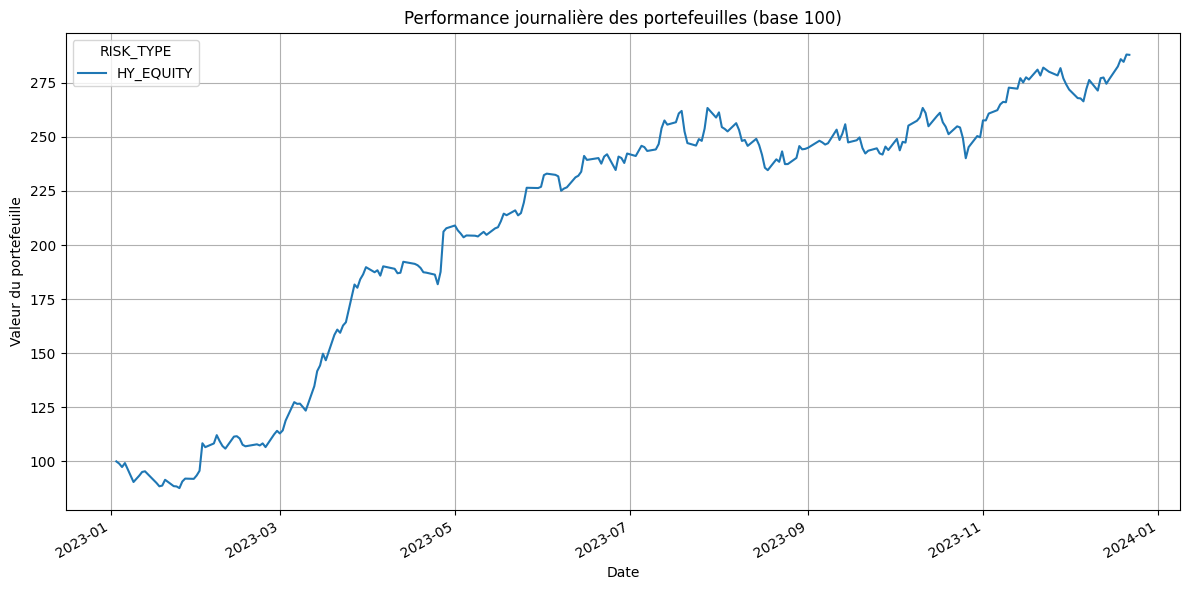

           Performance Totale (%)  Volatilité Annuelle (%)  Sharpe Ratio  \
HY_EQUITY                  187.95                    36.62          3.16   

           Max Drawdown (%)  CAGR (%)  Meilleure Perf Hebdo (%)  \
HY_EQUITY            -12.35    198.49                     18.85   

           Pire Perf Hebdo (%)  
HY_EQUITY                -4.56  
Le portefeuille HY_EQUITY du manager Amanda Mcneil affiche la performance totale la plus élevée (187.95%).
Le portefeuille HY_EQUITY du manager Amanda Mcneil a la volatilité annuelle la plus faible (36.62%), illustrant une meilleure stabilité.
Le portefeuille HY_EQUITY du manager Amanda Mcneil présente le meilleur Sharpe Ratio (3.16), indiquant le couple rendement/risque le plus efficace.
Le portefeuille HY_EQUITY du manager Amanda Mcneil présente le plus faible drawdown (-12.35%), signe d'une bonne résistance en période de baisse.
Le portefeuille HY_EQUITY du manager Amanda Mcneil affiche le meilleur taux de croissance annualisé (198.49%

In [15]:
analyzer = PortfolioAnalyzer("Fund.db")
analyzer.plot_portfolio_performance()
metrics_df = analyzer.compute_portfolio_metrics()
print(metrics_df)
analyzer.describe_best_portfolios()